In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

from scipy.stats import norm

eps = 1.e-8

In [20]:
def make_polynomial(degree=5):
  return make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(), LinearRegression())

def make_ridge(degree=5, alpha=1.):
  return make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(), Ridge(alpha=alpha))

def make_ridge_cv(degree=5, min_alpha=1.e-5, max_alpha=1.e+2, num_alphas=100):
  alphas = np.exp(np.linspace(np.log(min_alpha), np.log(max_alpha), num_alphas))
  return make_pipeline(PolynomialFeatures(degree=degree), StandardScaler(), RidgeCV(alphas=alphas))

In [17]:
class DifferentialRegression:

  def __init__(self, degree=5, alpha=1.0):
    self.degree = degree
    self.polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
    self.alpha = alpha

  def fit(self, x, y, z):
    self.phi_ = self.polynomial_features.fit_transform(x)
    self.powers_ = self.polynomial_features.powers_

    self.dphi_ = self.phi_[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + eps)

    self.lamj_ = ((y ** 2).mean(axis=0) / (z ** 2).mean(axis=0)).reshape(1, 1, -1)
    self.dphiw_ = self.dphi_ * self.lamj_

    phiTphi = np.tensordot(self.dphiw_, self.dphi_, axes=([0, 2], [0, 2]))
    phiTz = np.tensordot(self.dphiw_, z, axes=([0, 2], [0, 1])).reshape(-1, 1)

    inv = np.linalg.pinv(self.phi_.T @ self.phi_ + self.alpha * phiTphi, hermitian=True)
    self.beta_ = (inv @ (self.phi_.T @ y + self.alpha * phiTz)).reshape(-1, 1)

  def predict(self, x, predict_derivs=False):
    phi = self.polynomial_features.transform(x)
    y_pred = phi @ self.beta_

    if predict_derivs:
      dphi = phi[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + eps)
      z_pred = np.tensordot(dphi, self.beta_, (1, 0)).reshape(dphi.shape[0], -1)
      return y_pred, z_pred
    else:
      return y_pred

In [12]:
def black_scholes(S, K, sigma, T):
  temp = sigma * np.sqrt(T)
  d1 = np.log(S / K) / temp + .5 * temp
  d2 = d1 - temp
  return S * norm.cdf(d1) - K * norm.cdf(d2)

def black_scholes_delta(S, K, sigma, T):
  temp = sigma * np.sqrt(T)
  d1 = np.log(S / K) / temp + .5 * temp
  return norm.cdf(d1)

class BlackScholesSimulator:
  
  def __init__(self, sigma, K, T, lower=10, upper=200):
    self.sigma = sigma
    self.sigma2 = sigma * sigma
    self.K = K
    self.T = T 
    self.sqrtT = np.sqrt(T) 
    self.lower = lower 
    self.upper = upper 

  def trainSet(self, m, seed=0):
    s0 = np.linspace(self.lower, self.upper, m)

    np.random.seed(seed)
    wT = np.random.normal(size=m)
    sT = s0*np.exp(-.5 * self.sigma2 * self.T + self.sigma * self.sqrtT * wT)
    pay = np.maximum(0, sT - self.K)
    deriv = np.where(sT > self.K, sT / s0, 0)

    return s0.reshape(-1, 1), pay.reshape(-1, 1), deriv.reshape(-1, 1)

  def testSet(self, m):
    s0 = np.linspace(self.lower, self.upper, m)
    val = black_scholes(s0, self.K, self.sigma, self.T)
    delta = black_scholes_delta(s0, self.K, self.sigma, self.T)
    return s0.reshape(-1, 1), val.reshape(-1, 1), delta.reshape(-1, 1)


In [13]:
sigma = .2
K = 110
T = 2

m = 200
M = 5000
lower = 10
upper = 200

seed = np.random.randint(8192)
print("useing seed", seed)

useing seed 2382


In [14]:
bs = BlackScholesSimulator(sigma, K, T, lower, upper)
x_train, y_train, z_train = bs.trainSet(m, seed=seed)
x_test, y_test, z_test = bs.testSet(M)

In [21]:
lin_reg = make_polynomial()
lin_reg.fit(x_train, y_train)
lin_pred = lin_reg.predict(x_test)

ridge_reg = make_ridge_cv()
ridge_reg.fit(x_train, y_train)
ridge_pred = ridge_reg.predict(x_test)
alpha = ridge_reg['ridgecv'].alpha_

diff_reg = DifferentialRegression()
diff_reg.fit(x_train, y_train, z_train)
diff_pred = diff_reg.predict(x_test)

Ridge regression alpha = 0.0057


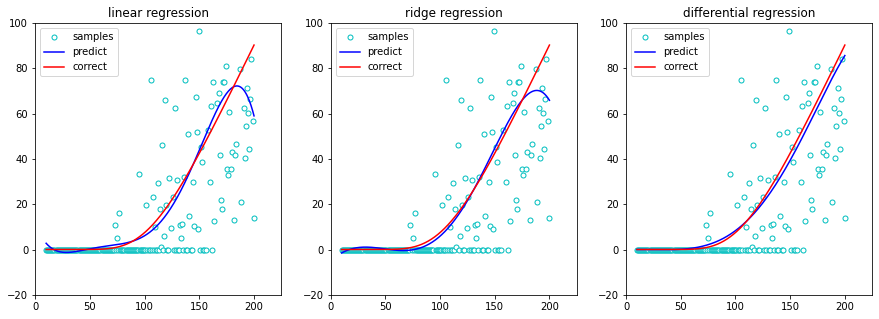

In [22]:
# plot results

def plot_one(ax, x_train, y_train, x_test, y_test, pred):
    ax.set_xlim(0, 225)
    ax.set_ylim(-20, 100)
    samples, = ax.plot(x_train, y_train, 'co', markersize=5, markerfacecolor="white", label="samples")
    predict, = ax.plot(x_test, pred, 'b-', label="predict")
    correct, = ax.plot(x_test, y_test, 'r-', label="correct")
    return samples, predict, correct

def plot_multi(x_train, y_train, x_test, y_test, titles, preds):
    nplots = len(preds)
    nrows = (nplots - 1) // 3 + 1
    ncols = min(nplots, 3)
    
    fig, axs = plt.subplots(nrows, ncols, squeeze=False)
    fig.set_size_inches(ncols * 5, nrows * 5)

    lines = []
    for i, ax in enumerate(axs.flatten()):
        if i < nplots:
            samples, predict, correct = plot_one(ax, x_train, y_train, x_test, y_test, preds[i])
            lines.extend([samples, predict, correct])
            ax.legend()
            ax.set_title(titles[i])
    
    return fig, lines
            
print("Ridge regression alpha = %.4f" % alpha)
fig, lines = plot_multi(x_train, y_train, x_test, y_test, 
                        ["linear regression", "ridge regression", "differential regression"],
                        [lin_pred, ridge_pred, diff_pred])

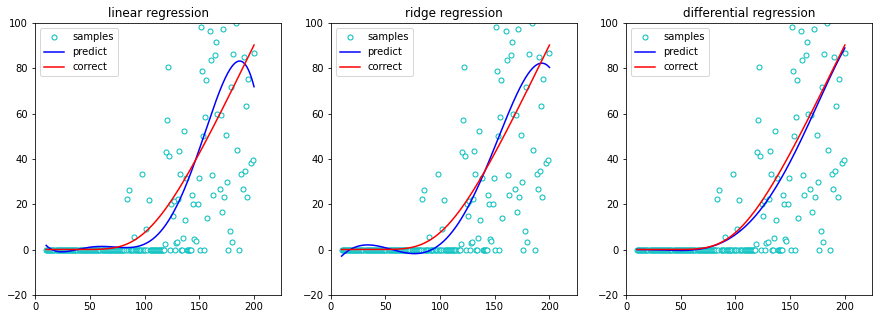

In [24]:
fig, lines = plot_multi(x_train, y_train, x_test, y_test, 
                        ["linear regression", "ridge regression", "differential regression"],
                        [lin_pred, ridge_pred, diff_pred])

def animate(i):
    seed = np.random.randint(8192)
    x_train, y_train, z_train = bs.trainSet(m, seed=seed)
    
    lin_reg.fit(x_train, y_train)
    lin_pred = lin_reg.predict(x_test)
    ridge_reg.fit(x_train, y_train)
    ridge_pred = ridge_reg.predict(x_test)
    diff_reg.fit(x_train, y_train, z_train)
    diff_pred = diff_reg.predict(x_test)
    
    lines[0].set_data(x_train, y_train)
    lines[1].set_data(x_test, lin_pred)
    lines[3].set_data(x_train, y_train)
    lines[4].set_data(x_test, ridge_pred)
    lines[6].set_data(x_train, y_train)
    lines[7].set_data(x_test, diff_pred)
    
    return lines

FuncAnimation(fig, animate, init_func=None, frames=200, interval=500, blit=True)